Esse código tem como finalidade realizar uma análise completa de dados de procedimentos hospitalares. O objetivo é extrair insights gerenciais, gerar KPIs (Key Performance Indicators - Indicadores-Chave de Desempenho), detectar alertas e visualizar tudo em um painel executivo.

In [ ]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configurações visuais
sns.set_style("whitegrid")
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

- `sns.set_style("whitegrid"): `Define o estilo visual dos gráficos do Seaborn para um fundo branco com grades cinzas, o que facilita a leitura.
- `plt.style.use('ggplot'):` Aplica um estilo popular chamado 'ggplot' (inspirado na biblioteca de R) aos gráficos, conhecido por sua estética limpa e profissional.
- `plt.rcParams['figure.dpi'`] e` plt.rcParams['font.size']:` Configuram parâmetros globais do matplotlib. O primeiro aumenta a resolução das figuras (DPI - dots per inch), tornando-as mais nítidas. O segundo define um tamanho de fonte padrão para os textos nos gráficos.

Carregando dados hospitalares...
Dados carregados: 33,867 procedimentos de 2020 a 2025
Gerando relatório de gestão hospitalar...
Dashboard salvo em: relatorio_gestao_hospitalar/dashboard_executivo.png
Relatório completo gerado em: relatorio_gestao_hospitalar/
Dashboard: dashboard_executivo.png
KPIs: relatorio_kpis.txt

RESUMO EXECUTIVO:
   Total de procedimentos: 33,867
   Crescimento anual: -69.6%
   Média mensal: 529 procedimentos

ALERTAS:
   Tendência de DECLÍNIO: -13.2% nos últimos 6 meses
   ALTA concentração: 99.1% em apenas 3 convênios


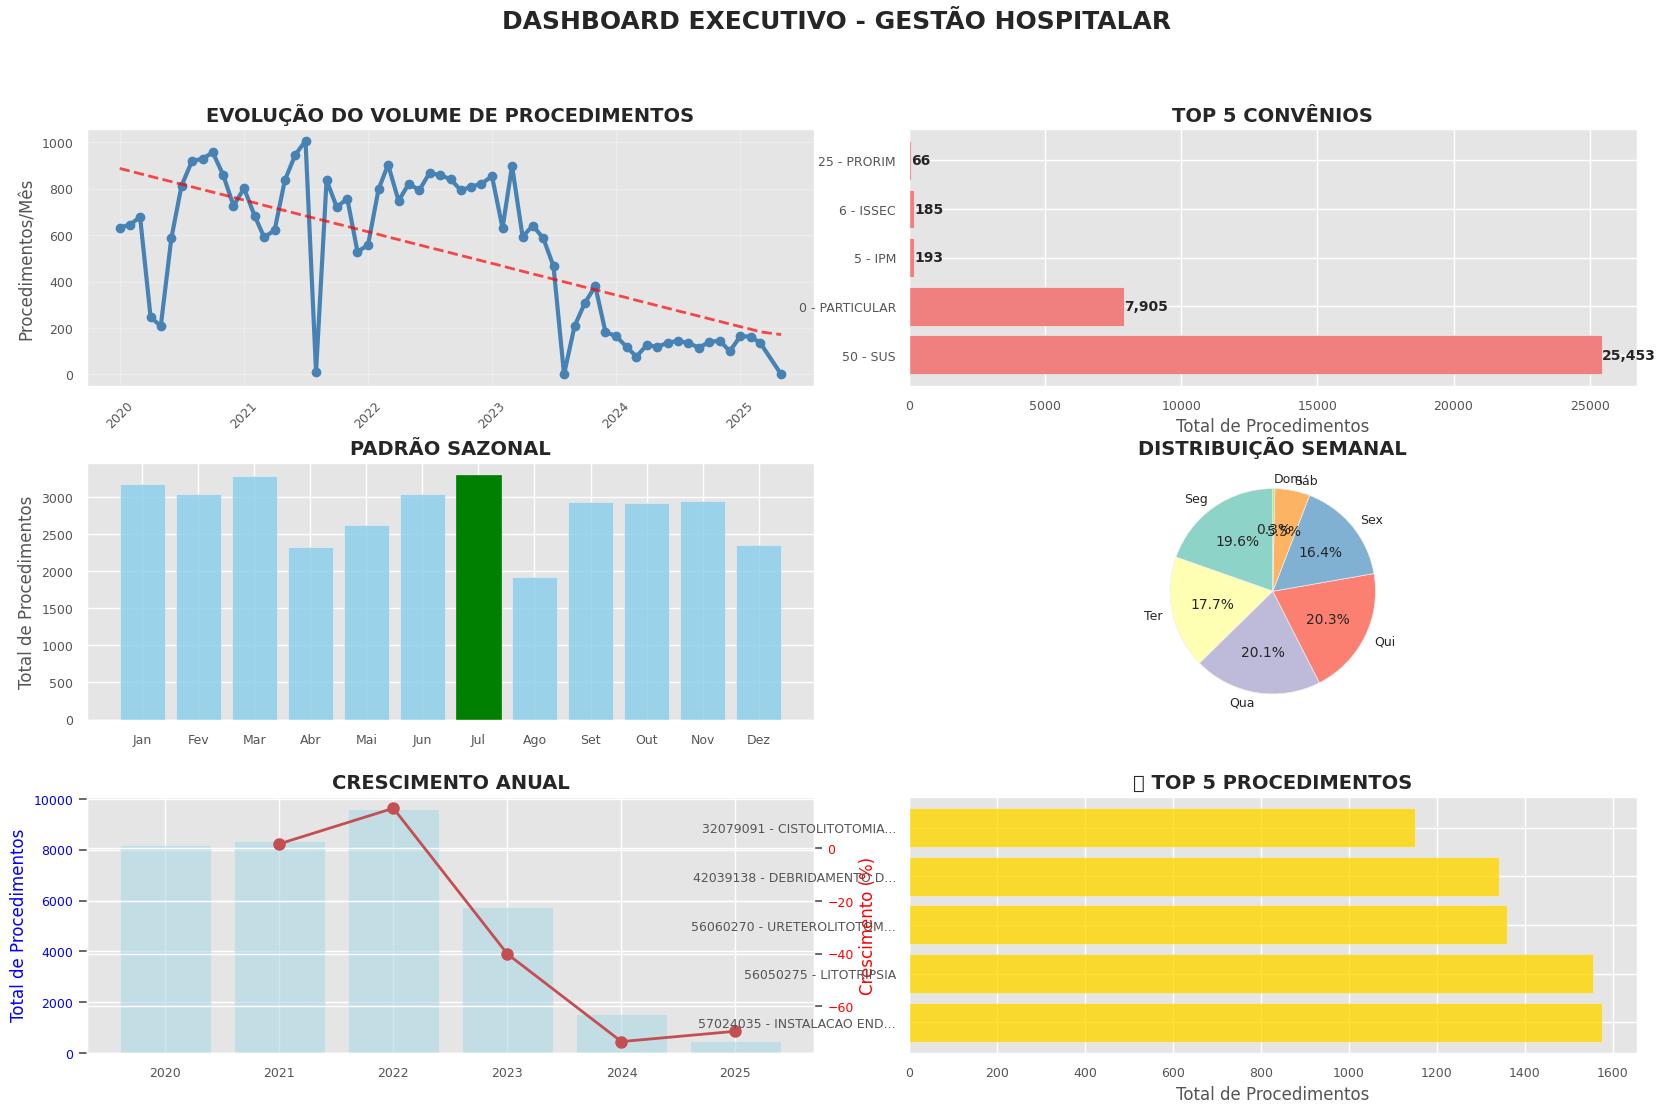

In [ ]:
class HospitalAnalytics:
    """Classe para análise de dados hospitalares focada em gestão"""
    def __init__(self, caminho_csv):
        self.df = self.carregar_dados(caminho_csv)
        self.pasta_saida = 'relatorio_gestao_hospitalar'

    def carregar_dados(self, caminho_csv):
        """Carrega e prepara os dados com validações"""
        try:
            print("Carregando dados hospitalares...")
            df = pd.read_csv(caminho_csv, parse_dates=['DATA_CIRURGIA'], low_memory=False)

            # Validações críticas para gestão
            df = df[df['DATA_CIRURGIA'].dt.year <= 2026]
            df = df.dropna(subset=['DATA_CIRURGIA', 'CONVENIO'])

            # Variáveis derivadas essenciais
            df['MES'] = df['DATA_CIRURGIA'].dt.month
            df['ANO'] = df['DATA_CIRURGIA'].dt.year
            df['ANO_MES'] = df['DATA_CIRURGIA'].dt.to_period('M').dt.to_timestamp()
            df['DIA_SEMANA'] = df['DATA_CIRURGIA'].dt.day_name()
            df['TRIMESTRE'] = df['DATA_CIRURGIA'].dt.quarter

            print(f"Dados carregados: {len(df):,} procedimentos de {df['ANO'].min()} a {df['ANO'].max()}")
            return df

        # Tratamento de erros
        except FileNotFoundError:
            print(f"Arquivo não encontrado: {caminho_csv}")
            return None
        except Exception as e:
            print(f"Erro ao carregar dados: {e}")
            return None

    def gerar_kpis_gestao(self):
        """Gera KPIs essenciais para gestão hospitalar"""
        if self.df is None:
            return None

        kpis = {
            'total_procedimentos': len(self.df),
            'periodo_analise': f"{self.df['ANO'].min()} - {self.df['ANO'].max()}",
            'media_mensal': len(self.df) / len(self.df['ANO_MES'].unique()),
            'convenios_ativos': self.df['CONVENIO'].nunique(),
            'especialidades_ativas': self.df['ESPECIALIDADE'].nunique(),
            'procedimentos_unicos': self.df['B_CD_PROCEDIMENTO_FN_DS_PROCED'].nunique(),
            'crescimento_anual': self.df.groupby('ANO').size().pct_change().iloc[-1] * 100,
            'mes_maior_volume': self.df.groupby('MES').size().idxmax(),
            'dia_semana_maior_volume': self.df['DIA_SEMANA'].value_counts().index[0]
        }
        return kpis

    def detectar_alertas_gestao(self):
        """Detecta alertas importantes para gestão"""
        alertas = []

        # 1. Outliers de volume (períodos críticos)
        dados_mensais = self.df.groupby('ANO_MES').size()
        q75, q25 = np.percentile(dados_mensais, [75, 25])
        iqr = q75 - q25
        outliers_baixos = dados_mensais[dados_mensais < (q25 - 1.5 * iqr)]
        outliers_altos = dados_mensais[dados_mensais > (q75 + 1.5 * iqr)]

        if len(outliers_baixos) > 0:
            alertas.append(f"{len(outliers_baixos)} períodos com volume anormalmente BAIXO")
        if len(outliers_altos) > 0:
            alertas.append(f"{len(outliers_altos)} períodos com volume anormalmente ALTO")

        # 2. Tendência de crescimento
        crescimento_mensal = dados_mensais.pct_change().tail(6).mean() * 100
        if crescimento_mensal < -5:
            alertas.append(f"Tendência de DECLÍNIO: {crescimento_mensal:.1f}% nos últimos 6 meses")
        elif crescimento_mensal > 10:
            alertas.append(f"Crescimento ACELERADO: {crescimento_mensal:.1f}% nos últimos 6 meses")

        # 3. Concentração excessiva em poucos convênios
        concentracao_convenio = (self.df['CONVENIO'].value_counts().head(3).sum() / len(self.df)) * 100
        if concentracao_convenio > 70:
            alertas.append(f"ALTA concentração: {concentracao_convenio:.1f}% em apenas 3 convênios")

        return alertas

    def plot_dashboard_executivo(self, salvar=True):
        """Dashboard principal para executivos"""
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

        # 1. Evolução temporal (principal)
        ax1 = fig.add_subplot(gs[0, :2])
        dados_mensais = self.df.groupby('ANO_MES').size()
        ax1.plot(dados_mensais.index, dados_mensais.values, 'o-', linewidth=3, markersize=6, color='steelblue')
        ax1.set_title('EVOLUÇÃO DO VOLUME DE PROCEDIMENTOS', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Procedimentos/Mês')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # Adicionar linha de tendência
        z = np.polyfit(range(len(dados_mensais)), dados_mensais.values, 1)
        p = np.poly1d(z)
        ax1.plot(dados_mensais.index, p(range(len(dados_mensais))), "--", alpha=0.7, color='red', linewidth=2)

        # 2. Top 5 Convênios
        ax2 = fig.add_subplot(gs[0, 2:])
        top_convenios = self.df['CONVENIO'].value_counts().head(5)
        bars = ax2.barh(range(len(top_convenios)), top_convenios.values, color='lightcoral')
        ax2.set_title('TOP 5 CONVÊNIOS', fontsize=14, fontweight='bold')
        ax2.set_yticks(range(len(top_convenios)))
        ax2.set_yticklabels([nome[:20] + '...' if len(nome) > 20 else nome for nome in top_convenios.index])
        ax2.set_xlabel('Total de Procedimentos')

        # Adicionar valores nas barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:,}',
                    ha='left', va='center', fontweight='bold')

        # 3. Sazonalidade mensal
        ax3 = fig.add_subplot(gs[1, :2])
        sazonalidade = self.df.groupby('MES').size()
        meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
        bars = ax3.bar(range(1, 13), sazonalidade.values, color='skyblue', alpha=0.8)
        ax3.set_title('PADRÃO SAZONAL', fontsize=14, fontweight='bold')
        ax3.set_xticks(range(1, 13))
        ax3.set_xticklabels(meses)
        ax3.set_ylabel('Total de Procedimentos')

        # Destacar mês de maior volume
        max_mes = sazonalidade.idxmax()
        bars[max_mes-1].set_color('green')
        bars[max_mes-1].set_alpha(1.0)

        # 4. Distribuição por dia da semana
        ax4 = fig.add_subplot(gs[1, 2:])
        dias_semana = self.df['DIA_SEMANA'].value_counts()
        dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dias_pt = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
        volume_dias = [dias_semana.get(dia, 0) for dia in dias_ordem]

        ax4.pie(volume_dias, labels=dias_pt, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
        ax4.set_title('DISTRIBUIÇÃO SEMANAL', fontsize=14, fontweight='bold')

        # 5. Crescimento anual
        ax5 = fig.add_subplot(gs[2, :2])
        crescimento_anual = self.df.groupby('ANO').size()
        variacao = crescimento_anual.pct_change() * 100

        ax5_twin = ax5.twinx()
        ax5.bar(crescimento_anual.index, crescimento_anual.values, alpha=0.6, color='lightblue', label='Volume')
        ax5_twin.plot(variacao.index[1:], variacao.values[1:], 'ro-', linewidth=2, markersize=8, label='Crescimento %')

        ax5.set_title('CRESCIMENTO ANUAL', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Total de Procedimentos', color='blue')
        ax5_twin.set_ylabel('Crescimento (%)', color='red')
        ax5.tick_params(axis='y', labelcolor='blue')
        ax5_twin.tick_params(axis='y', labelcolor='red')

        # 6. Top 5 Procedimentos
        ax6 = fig.add_subplot(gs[2, 2:])
        top_proc = self.df['B_CD_PROCEDIMENTO_FN_DS_PROCED'].value_counts().head(5)
        proc_nomes = [nome[:25] + '...' if len(nome) > 25 else nome for nome in top_proc.index]

        ax6.barh(range(len(top_proc)), top_proc.values, color='gold', alpha=0.8)
        ax6.set_title('🔬 TOP 5 PROCEDIMENTOS', fontsize=14, fontweight='bold')
        ax6.set_yticks(range(len(top_proc)))
        ax6.set_yticklabels(proc_nomes)
        ax6.set_xlabel('Total de Procedimentos')

        plt.suptitle('DASHBOARD EXECUTIVO - GESTÃO HOSPITALAR', fontsize=18, fontweight='bold', y=0.98)

        if salvar:
            os.makedirs(self.pasta_saida, exist_ok=True)
            plt.savefig(f'{self.pasta_saida}/dashboard_executivo.png', bbox_inches='tight', dpi=300)
            print(f"Dashboard salvo em: {self.pasta_saida}/dashboard_executivo.png")

        return fig

    def gerar_relatorio_completo(self):
        """Gera relatório completo para gestão"""
        if self.df is None:
            print("Dados não carregados")
            return

        os.makedirs(self.pasta_saida, exist_ok=True)

        print("Gerando relatório de gestão hospitalar...")

        # KPIs principais
        kpis = self.gerar_kpis_gestao()
        alertas = self.detectar_alertas_gestao()

        # Dashboard principal
        self.plot_dashboard_executivo(salvar=True)

        # Relatório textual
        with open(f'{self.pasta_saida}/relatorio_kpis.txt', 'w', encoding='utf-8') as f:
            f.write("RELATÓRIO DE KPIs - GESTÃO HOSPITALAR\n")
            f.write("=" * 50 + "\n\n")

            f.write("INDICADORES PRINCIPAIS:\n")
            f.write(f"• Total de Procedimentos: {kpis['total_procedimentos']:,}\n")
            f.write(f"• Período de Análise: {kpis['periodo_analise']}\n")
            f.write(f"• Média Mensal: {kpis['media_mensal']:.0f} procedimentos\n")
            f.write(f"• Convênios Ativos: {kpis['convenios_ativos']}\n")
            f.write(f"• Especialidades Ativas: {kpis['especialidades_ativas']}\n")
            f.write(f"• Crescimento Anual: {kpis['crescimento_anual']:+.1f}%\n\n")

            f.write("ALERTAS DE GESTÃO:\n")
            if alertas:
                for alerta in alertas:
                    f.write(f"{alerta}\n")
            else:
                f.write("Nenhum alerta crítico detectado\n")

            f.write(f"\nRelatório gerado em: {datetime.now().strftime('%d/%m/%Y %H:%M')}\n")

        print(f"Relatório completo gerado em: {self.pasta_saida}/")
        print(f"Dashboard: dashboard_executivo.png")
        print(f"KPIs: relatorio_kpis.txt")

        # Exibir KPIs no terminal
        print("\n" + "="*60)
        print("RESUMO EXECUTIVO:")
        print(f"   Total de procedimentos: {kpis['total_procedimentos']:,}")
        print(f"   Crescimento anual: {kpis['crescimento_anual']:+.1f}%")
        print(f"   Média mensal: {kpis['media_mensal']:.0f} procedimentos")

        if alertas:
            print("\nALERTAS:")
            for alerta in alertas[:3]:  # Mostrar apenas os 3 principais
                print(f"   {alerta}")

        print("="*60)

# Exemplo de uso otimizado
def executar_analise_gestao_hospitalar(caminho_csv):
    """Função principal para análise de gestão hospitalar"""
    analytics = HospitalAnalytics(caminho_csv)
    analytics.gerar_relatorio_completo()
    return analytics

# Para executar:
analytics = executar_analise_gestao_hospitalar('/content/DATAFRAME UNIFICADO.csv')

**Sobre a classe** `HospitalAnalytics`


*  ela encapsula toda a lógica da análise.
- Quando um objeto `HospitalAnalytics` é criado, este método é chamado automaticamente.
- `self.df = self.carregar_dados(caminho_csv`): Imediatamente chama o método carregar_dados com o caminho do arquivo CSV fornecido e armazena o DataFrame resultante na variável self.df.
- `self.pasta_saida = 'relatorio_gestao_hospitalar'`: Define o nome da pasta onde o relatório e os gráficos serão salvos.




---



**Sobre a função** `carregar_dados(self, caminho_csv)`


*   **Carregamento e preparação:** Lê o arquivo CSV. `parse_dates=['DATA_CIRURGIA'] `instrui o Pandas a converter automaticamente a coluna `DATA_CIRURGIA` para o formato de data, o que é crucial para análises temporais. `low_memory=False` pode acelerar a leitura de arquivos grandes.

*   **Validação de dados:**
  - `df[df['DATA_CIRURGIA'].dt.year <= 2026]`: Remove quaisquer registros com datas de cirurgia improváveis ou futuras (após 2026), garantindo a qualidade dos dados.
  - `df.dropna(...)`: Remove linhas onde as colunas `DATA_CIRURGIA` ou `CONVENIO` estão vazias, pois são essenciais para a análise.

* **Engenharia de features (variáveis derivadas):** Cria novas colunas a partir da `DATA_CIRURGIA` para facilitar análises específicas:
  - `MES`, `ANO`, `DIA_SEMANA`, `TRIMESTRE`: Extrai componentes da data.
  - `ANO_MES`: Cria uma data que representa o início do mês, útil para agrupar dados mensalmente.





---



**Sobre a função** `gerar_kpis_gestao(self)`


*   **Calcula indicadores-chave:**  as métricas fundamentais para a gestão:
  - `total_procedimentos`: contagem total de cirurgias.
  - `periodo_analise`: anos mínimo e máximo nos dados.
  - `media_mensal`: média de procedimentos por mês.
  - `convenios_ativos`, `especialidades_ativas`, `procedimentos_unicos`: contagem de itens únicos para entender a diversidade de operações.
  - `crescimento_anual`: usa `pct_change()` para calcular a variação percentual do volume de procedimentos do último ano em relação ao penúltimo.
  - `mes_maior_volume` e `dia_semana_maior_volume`: identifica os períodos de pico de atividade.





---



**Sobre a função** `detectar_alertas_gestao(self)`


* **Identificação de riscos e oportunidades**:
  - **Detecção de outliers**: usa o método estatístico de "Intervalo Interquartil" (IQR) para encontrar meses com volume de procedimentos "anormalmente" alto ou baixo. Isso pode indicar problemas (como uma queda súbita na demanda) ou picos que precisam de planejamento.
  -**Tendência recente**: calcula a média do crescimento percentual dos últimos 6 meses. Se for muito negativa (< -5%), alerta para um declínio. Se for muito positiva (> 10%), alerta para um crescimento acelerado que pode exigir mais recursos.
  -**Concentração de convênios**: verifica se os 3 principais convênios representam mais de 70% do total de procedimentos. Uma alta concentração pode ser um risco de negócio se um desses convênios rescindir o contrato.




---



**Sobre a função** `plot_dashboard_executivo(self, salvar=True)`
* Ela cria a figura com os 6 gráficos
  - `fig = plt.figure(...)` e `gs = fig.add_gridspec(...)`: criam a "tela" (figura) e a dividem em uma grade (3 linhas por 4 colunas) para organizar os gráficos.
  - `ax1 = fig.add_subplot(...)`: cada `ax` representa um dos gráficos no painel. A explicação de cada gráfico está na próxima seção.
  - `plt.suptitle(...)`: adiciona um título principal a todo o painel.
  - `plt.savefig(...)`: se `salvar=True`, salva a figura como um arquivo de imagem png




---



**Sobre a função** `gerar_relatorio_completo(self)`


* Ela junta todas as peças
  - chama `gerar_kpis_gestao()` e `detectar_alertas_gestao()` para obter os dados.
  - chama `plot_dashboard_executivo()` para criar e salvar o painel visual.
  - cria um arquivo de texto (`relatorio_kpis.txt`) e escreve um resumo formatado dos KPIs e alertas.
  - imprime um resumo executivo no terminal para feedback imediato.




---



**Função de execução** `executar_analise_gestao_hospitalar(caminho_csv)`


*  Ponto de entrada: esta função simplifica a execução; ela cria a instância da classe `HospitalAnalytics` e chama o método `gerar_relatorio_completo` para rodar toda a análise com uma única chamada de função.

* A última linha é a que efetivamente inicia todo o processo, passando o caminho do arquivo de dados.






---
# Explicação dos gráficos


1.  **EVOLUÇÃO DO VOLUME DE PROCEDIMENTOS**
- **O que faz?** Mostra o número total de procedimentos realizados a cada mês ao longo do tempo em um gráfico de linha. Uma linha de tendência vermelha tracejada é sobreposta para indicar a direção geral do crescimento.

- **Para que serve?** É o principal indicador da atividade do hospital. Permite à gestão visualizar rapidamente se o volume de negócios está crescendo, diminuindo ou estagnado. A linha de tendência ajuda a ignorar as flutuações mensais e focar na performance de longo prazo.

2. **TOP 5 CONVÊNIOS**
- **O que faz?** É um gráfico de barras horizontais que mostra os 5 convênios que trazem o maior número de procedimentos para o hospital.
- **Para que serve?** Identifica os parceiros de negócio mais importantes. Essa informação é crucial para a gestão de relacionamento, negociação de contratos e para entender a dependência de receita. Se um único convênio domina a lista, isso pode representar um risco.

3. **PADRÃO SAZONAL**
- **O que faz?** Mostra o volume total de procedimentos agregados por mês do ano (todos os "Janeiros" juntos, todos os "Fevereiros", etc.). A barra do mês com o maior volume histórico é destacada em verde.
- **Para que serve?** Revela padrões de sazonalidade. Por exemplo, pode mostrar que certos meses (como os de férias) têm menos cirurgias eletivas. Isso ajuda no planejamento de pessoal, gestão de estoque e campanhas de marketing para impulsionar a demanda em meses mais fracos.

4. **DISTRIBUIÇÃO SEMANAL**
- **O que faz?** Um gráfico de pizza que divide o volume total de procedimentos pelos dias da semana (Segunda, Terça, etc.).
- **Para que serve?** Ajuda a entender a distribuição da carga de trabalho ao longo da semana. É fundamental para otimizar o agendamento de salas de cirurgia, alocar equipes de enfermagem e administrar o fluxo de pacientes, evitando gargalos em dias de pico.

5. **CRESCIMENTO ANUAL**
- **O que faz?** É um gráfico combinado. As barras azuis mostram o volume total de procedimentos a cada ano. A linha vermelha, em um eixo separado à direita, mostra a variação percentual de crescimento de um ano para o outro.
- **Para que serve?** Fornece uma visão macro do desempenho anual. Enquanto as barras mostram a escala da operação, a linha de crescimento destaca a taxa de aceleração ou desaceleração, o que é um indicador-chave da saúde financeira e estratégica da instituição.

6. **TOP 5 PROCEDIMENTOS**
- **O que faz?** Similar ao gráfico de convênios, este mostra os 5 procedimentos cirúrgicos mais realizados no hospital.
- **Para que serve?** Identifica as "especialidades da casa". Essa informação é vital para o planejamento de recursos, como a compra de equipamentos específicos, a contratação de especialistas e a gestão de materiais cirúrgicos. Também pode guiar decisões de investimento e expansão de serviços.